In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, PrecisionRecallDisplay
from keras.utils import plot_model
import pandas as pd
import seaborn as sns
import joblib

(39000, 14)


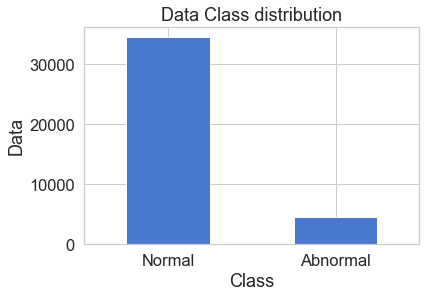

In [10]:
# Generate some sample data for the autoencoder
# x_train = np.random.rand(1000, 12)
# x_test = np.random.rand(100, 12)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

df = pd.read_csv("Autoencoder1.csv")
print(df.shape)

LABELS = ["Normal", "Abnormal"]

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cmath import pi

data = df.drop(['Time'], axis=1)
y_true = df['Class']

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

In [11]:
X_train, X_test = train_test_split(data, test_size=0.5, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

def MinmaxNorm(data1, data2, label):
    for i in label:
        a = data1[i]
        b = data2[i]
        x_max = max(a)
        x_min = min(a)
        for j in list(range(a.shape[0])):
            a.iloc[j] = (a.iloc[j] - x_min) / (x_max - x_min)
        for k in list(range(b.shape[0])):
            b.iloc[k] = (b.iloc[k] - x_min) / (x_max - x_min)
    
    return data1, data2

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

X_train, X_test = MinmaxNorm(X_train, X_test, A)

# Add noise 
noise = 0.5
X_train_noisy = X_train + noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train = X_train.values
X_test = X_test.values

In [12]:
input_dim = 12
latent_dim = 4

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            # layers.Dense(8, activation='sigmoid',
            #             activity_regularizer=regularizers.l2(10e-3)),
            layers.Dense(8, activation='sigmoid'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(8, activation='relu'),
            layers.Dense(input_dim, activation='tanh'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
callback = EarlyStopping(monitor='val_loss', patience=3)
checkpointer = ModelCheckpoint(filepath="DAGMM_AE2_h8_l4",
                               monitor='val_loss',
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

batch_size = 12
nb_epochs = 100
history = autoencoder.fit(X_train_noisy, X_train,
                        epochs=nb_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.4,
                        callbacks=[checkpointer, tensorboard]).history

autoencoder.summary()

Epoch 1/100
864/864 [==============================] - 3s 2ms/step - loss: 0.0719 - val_loss: 0.0393
Epoch 2/100
864/864 [==============================] - 2s 2ms/step - loss: 0.0393 - val_loss: 0.0388
Epoch 3/100
864/864 [==============================] - 2s 2ms/step - loss: 0.0373 - val_loss: 0.0338
Epoch 4/100
864/864 [==============================] - 2s 3ms/step - loss: 0.0307 - val_loss: 0.0300
Epoch 5/100
864/864 [==============================] - 2s 3ms/step - loss: 0.0300 - val_loss: 0.0299
Epoch 6/100
864/864 [==============================] - 2s 2ms/step - loss: 0.0300 - val_loss: 0.0298
Epoch 7/100
864/864 [==============================] - 2s 2ms/step - loss: 0.0299 - val_loss: 0.0297
Epoch 8/100
864/864 [==============================] - 1s 1ms/step - loss: 0.0298 - val_loss: 0.0299
Epoch 9/100
864/864 [==============================] - 2s 2ms/step - loss: 0.0298 - val_loss: 0.0297
Epoch 10/100
864/864 [==============================] - 1s 2ms/step - loss: 0.0297 - val_lo

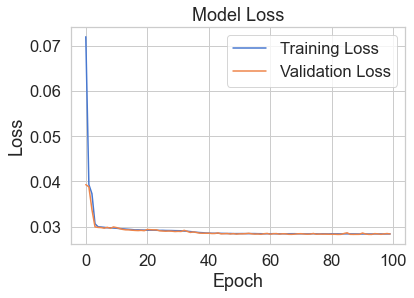

In [18]:
plt.plot(range(nb_epochs), history['loss'], label='Training Loss')
plt.plot(range(nb_epochs), history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Use the trained autoencoder to encode the training data
encoded_data = autoencoder.encoder(X_train).numpy()

# Fit a Gaussian Mixture Model with 2 components to the encoded training data
gmm = GaussianMixture(n_components=1)
gmm.fit(encoded_data)
saved_gmm = joblib.dump(gmm, 'DAGMM_GMM2_h8_l4_n1.pkl')

In [28]:
# Use the GMM to predict the probability densities for the encoded test data
encoded_test_data = autoencoder.encoder(X_test).numpy()
scores = gmm.score_samples(encoded_test_data) # score_samples: PDF of the test data

# Identify anomalies based on the GMM probability densities
threshold = np.percentile(scores, 6)
anomalies = X_test[scores < threshold]
# print("scores :", scores)
# print("threshold :", threshold)
# print("anomalies :", anomalies)
# print("scores < threshold :", scores < threshold)

# Calculate precision, recall, and F1 score
y_pred = np.zeros_like(scores)
y_pred[scores < threshold] = 1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")

Precision: 1.0000, Recall: 0.5182, F1 score: 0.6826


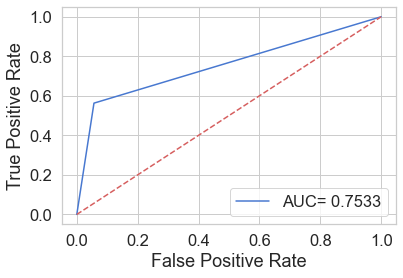

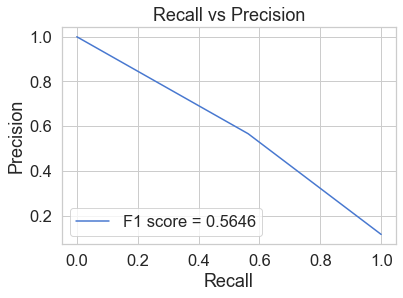

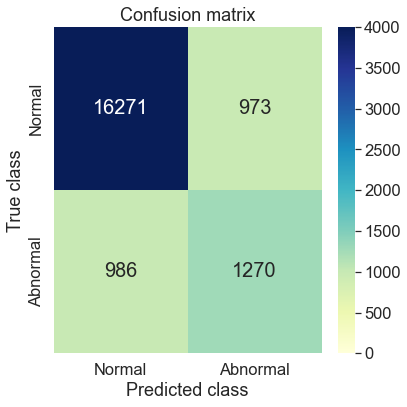

In [17]:
# Calculate precision, recall, and F1 score
y_pred = np.zeros_like(scores)
y_pred[scores < threshold] = 1
precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
f1 = f1_score(y_test, y_pred)
# PrecisionRecallDisplay.from_predictions(y_test, y_pred)
# plt.plot(ax=None,name=None)
# plt.xlim([-0.01, 1.0])
# plt.ylim([0.0, 1.001])

# ROC curve
plt.figure()
plt.plot(fpr, tpr, 'b', label='AUC= %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
# plt.xlim([-0.001, 1.0])
# plt.ylim([0.0, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

# precision recall curve
plt.figure()
plt.plot(recall, precision, 'b', label='F1 score = %0.4f'% f1)
plt.title('Recall vs Precision')
# plt.xlim([-0.001, 1.0])
# plt.ylim([0.0, 1.001])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show();

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
LABELS = ["Normal", "Abnormal"]
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, 
                        annot=True, fmt="d", annot_kws={'size': 20}, cmap="YlGnBu", 
                        vmin=0, vmax=4000);
plt.title("Confusion matrix")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()